In [1]:
using OrdinaryDiffEq
using Plots
using Random
using Optim
using LaTeXStrings
using BenchmarkTools

rng = Xoshiro(14588); # set random number generator seed

In [2]:
# Model parameters defined as constants
const g = 9.81 # gravity constant
const L = 1.0 # length of pendulum
const b = 0.025 # damping coefficient
const m = 0.5 # mass of pendulum

#Initial condition and simulation time span
const x0 = [0,π/2]
const tspan = (0.0,4)

(0.0, 4)

In [3]:
#Define the ODE model as a function which can be passed to a solver
function simplependulum!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - b/m*x[2]
    nothing
end

simplependulum! (generic function with 1 method)

In [4]:
#Define ODE problem and solve
prob = ODEProblem(simplependulum!, x0, tspan);
sol = solve(prob,Tsit5(),saveat=0.05);

In [5]:
# add noise to States
t, x = sol.t, sol.u # get time and state vector
N = length(t)
σ = 0.05; # standard deviation of measurement noise
y = reduce(hcat,x) + σ*randn(2,N); # add noise to state vector

In [6]:
function simplependulum_train_length!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/p[1])*sin(x[1]) - b/m*x[2]
    nothing
end;

In [7]:
prob = ODEProblem(simplependulum_train_length!, x0, tspan, [1.0]);
function costs(w, y, f)
    newprob = remake(f, p = w) # create an updated ODE problem with new parameters
    sol = solve(newprob,Tsit5(),saveat=0.05)
    x = reduce(hcat,sol.u)    
    return sum(abs2.(y .- x)) # return the sum of squared errors
end;

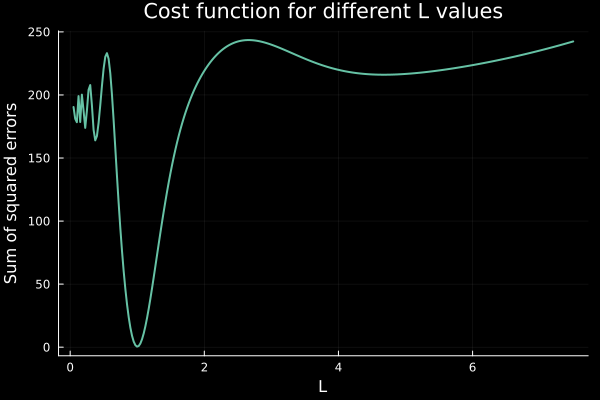

In [12]:
L_vec = LinRange(0.05, 7.5, 300) # create a vector of b values
cost_vec = zeros(length(L_vec))
for ii = 1:length(L_vec) # loop over all b values
    cost_vec[ii] = costs([L_vec[ii]], y, prob)
end

plot(L_vec, cost_vec, lw=2, background_color="#000000", palette = :Set2_5 ,legend=false) # plot the cost function
xlabel!("L")
ylabel!("Sum of squared errors")
title!("Cost function for different L values")


In [17]:
res = optimize(w -> costs(w, y, prob), [0.5], Newton(), Optim.Options(show_trace = true, extended_trace = true); autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.215024e+02     4.726812e+02
 * Current step size: 1.0
 * time: 0.006999969482421875
 * g(x): [472.6811658882466]
 * h(x): [-7264.331920827775;;]
 * x: [0.5]


     1     1.738412e+02     1.929778e+02
 * Current step size: 4.241321682485082
 * time: 0.006999969482421875
 * g(x): [192.97780708115417]
 * h(x): [48568.54652082201;;]
 * x: [0.22402240155957787]


     2     1.734821e+02     2.292910e+00
 * Current step size: 0.8901829368761406
 * time: 0.006999969482421875
 * g(x): [2.2929104039282056]
 * h(x): [59339.9474937992;;]
 * x: [0.22048543034332432]
     3     1.734820e+02     1.258598e-05
 * Current step size: 1.0014429539275909
 * time: 0.006999969482421875
 * g(x): [1.2585977600565457e-5]
 * h(x): [59450.06492134895;;]
 * x: [0.22044673433726128]


     4     1.734820e+02     5.798717e-07
 * Current step size: 0.9886793579723651
 * time: 0.006999969482421875
 * g(x): [-5.798717239713369e-7]
 * h(x): [59450.06551818032;;]
 * x: [0.22044673412795124]


     5     1.734820e+02     2.391199e-07
 * Current step size: 0.35576117252867395
 * time: 0.006999969482421875
 * g(x): [2.3911987767633036e-7]
 * h(x): [59450.06550828628;;]
 * x: [0.2204467341314213]


     6     1.734820e+02     4.171041e-08
 * Current step size: 0.47123680189673534
 * time: 0.006999969482421875
 * g(x): [4.171040757228184e-8]
 * h(x): [59450.06551369021;;]
 * x: [0.2204467341295259]


     7     1.734820e+02     1.754330e-11
 * Current step size: 1.001504248915303
 * time: 0.006999969482421875
 * g(x): [1.7543300145916874e-11]
 * h(x): [243.82384115112743;;]
 * x: [0.22044673412882324]


 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     1.734820e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 7.03e-13 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.19e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.25e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.21e-15 ≰ 0.0e+00
    |g(x)|                 = 1.75e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    25
    ∇f(x) calls:   25
    ∇²f(x) calls:  7


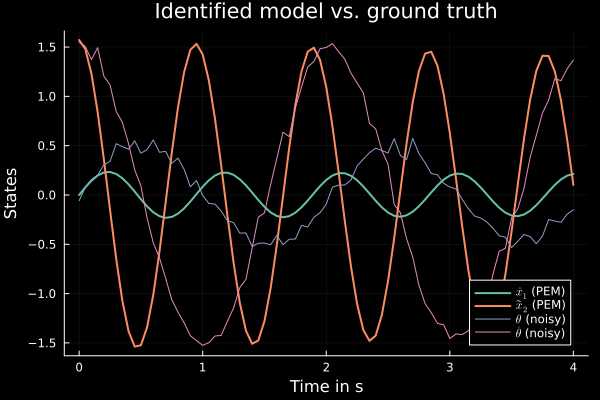

In [18]:
prob = ODEProblem(simplependulum_train_length!, x0, tspan, [0.22]);
sol = solve(prob,Tsit5(),saveat=0.05);

x = reduce(hcat,sol.u)
plot(sol.t,x',label=[L"$\hat{x}_1$ (PEM)" L"$̂\hat{x}_2$ (PEM)"],xlabel="Time in s",ylabel="States",title="Identified model vs. ground truth", lw=2,background_color="#000000", palette = :Set2_5)
plot!(sol.t,y',label=[L"$\theta$ (noisy)" L"$\dot{\theta}$ (noisy)"])